<a href="https://colab.research.google.com/github/Ofiarahman/Rent-Flat/blob/main/Copy_of_ozone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
!pip install statsmodels
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


# Ozone project for Introduction to Data Science

Load in the Helsinki data in .csv form first.

In [42]:
class Location:
    """A Location holds an ozone df, a monthly mean ozone df, and helper methods for plotting and forecasting."""

    def __init__(self, name):
        self.name = name
        self.read_data()

    def read_data(self):
        """Reads city data using the city name from data/<name>/*.csv."""
        files = glob.glob(f'./data/{self.name}/*.csv')
        ozone_df = pd.DataFrame()

        for file in files:
            ozone_df = pd.concat([ozone_df, pd.read_csv(file)])

        # Rename columns
        ozone_df = ozone_df.rename(columns = {'system:time_start': 'Date', 'O3_column_number_density': 'mol/m^2'})

        # Convert mol/m^2 to DU (Dobson Units)
        molm2_per_du = 4.4615 * 10**(-4)
        ozone_df['DU'] = ozone_df['mol/m^2'].apply(lambda observation: observation / molm2_per_du)

        # Convert Date to datetime and sort by date
        ozone_df['Date'] = pd.to_datetime(ozone_df['Date'])
        ozone_df = ozone_df.sort_values(by = 'Date').reset_index(drop = True)

        # Monthly ozone mean data
        ozone_monthly_df = ozone_df.copy()
        ozone_monthly_df['Date'] = ozone_df['Date'].apply(lambda date: date.strftime('%Y-%m'))
        ozone_monthly_df['Date'] = pd.to_datetime(ozone_monthly_df['Date'])
        ozone_monthly_df = ozone_monthly_df.groupby('Date').mean().reset_index()

        self.ozone_df = ozone_df
        self.ozone_monthly_df = ozone_monthly_df

    def fit_sarima(self, order=(1,1,1), seasonal_order=(1,1,1,12)):
        """Fits a SARIMA model to the monthly ozone data."""
        ozone_monthly = self.ozone_monthly_df
        model = SARIMAX(ozone_monthly['DU'], order=order, seasonal_order=seasonal_order)
        self.sarima_model = model.fit(disp=False)
        print(self.sarima_model.summary())

    def forecast_sarima(self, steps=60):
        """Forecasts ozone density using SARIMA for a specified number of steps (months)."""
        forecast = self.sarima_model.get_forecast(steps=steps)
        forecast_df = forecast.conf_int()
        forecast_df['forecast'] = self.sarima_model.predict(start=forecast_df.index[0], end=forecast_df.index[-1])
        forecast_df['Date'] = pd.date_range(start=self.ozone_monthly_df['Date'].max(), periods=steps+1, freq='M')[1:]
        return forecast_df

    def plot_forecast(self, forecast_df):
        """Plots the SARIMA forecast along with historical data."""
        ozone_monthly = self.ozone_monthly_df

        plt.figure(figsize=(14,7))
        plt.plot(ozone_monthly['Date'], ozone_monthly['DU'], label='Historical Data')
        plt.plot(forecast_df['Date'], forecast_df['forecast'], label='Forecast', color='red')
        plt.fill_between(forecast_df['Date'], forecast_df['lower DU'], forecast_df['upper DU'], color='pink', alpha=0.3)
        plt.title(f'Ozone Forecast for {self.name}')
        plt.legend()
        plt.show()
    def boxplot_yearly_ozone_data(self, col = 'DU', start_year = 2019, end_year = 2024):
        """Draw boxplots for yearly ozone data."""
        yearly_dens = []
        tick_labels = []
        ozone = self.ozone_df

        for year_i in range(end_year - start_year + 1):
            year_df = ozone[(ozone['Date'] >= f'{year_i + start_year}-01-01') & (ozone['Date'] < f'{year_i + start_year + 1}-01-01')]
            tick_labels.append(f'{year_i + start_year}')
            # Have to drop NaNs for boxplot to work. Otherwise it shows only an empty figure.
            yearly_dens.append(year_df[col].dropna())

        plt.title(f'Yearly ozone boxplots for {self.name}')
        plt.boxplot(yearly_dens)
        plt.ylabel(col)
        plt.xticks(range(1,7), tick_labels)
        plt.show()

    def plot_yearly_ozone_data(self, col = 'DU', start_year = 2019, end_year = 2024):
        """Draw yearly scatterplots of all ozone values, and the mean."""
        fig, axs = plt.subplots(2, 3)
        fig.suptitle(f'Yearly timeseries ozone data for {self.name}')
        ozone = self.ozone_df
        ozone_monthly = self.ozone_monthly_df
        row = 0

        for year_i in range(end_year - start_year + 1):
            if year_i > 0 and year_i % 3 == 0:
                row = row + 1

            year_df = ozone[(ozone['Date'] >= f'{year_i + start_year}-01-01') & (ozone['Date'] < f'{year_i + start_year + 1}-01-01')]
            year_avg_df = ozone_monthly[(ozone_monthly['Date'] >= f'{year_i + start_year}-01-01') & (ozone_monthly['Date'] < f'{year_i + start_year + 1}-01-01')]

            axs[row, year_i % 3].scatter(year_df['Date'], year_df[col], s = 1, marker = 'o')
            axs[row, year_i % 3].plot(year_avg_df['Date'], year_avg_df[col], c='red', marker = '.')

            axs[row, year_i % 3].set_title(f'{year_i + start_year}')
            axs[row, year_i % 3].xaxis.set_ticks([f'{year_i + start_year}-{month:02d}' + '-01' for month in range(1,13)])
            axs[row, year_i % 3].xaxis.set_ticklabels([f'{month}' for month in range(1,13)])

            # Only print the ylabel on the left side axes
            if year_i == 0 or year_i == 3:
                axs[row, year_i % 3].set_ylabel(col)

            # Only print the xlabel on the lower row
            if year_i > 2:
                axs[row, year_i % 3].set_xlabel('month')

        fig.set_figwidth(16)
        fig.set_figheight(8)
        fig.legend(['Daily observations', 'Monthly average'])
        plt.show()

    def plot_all_ozone_data(self, col = 'DU'):
        """Draw all ozone data in one figure."""
        ozone = self.ozone_df
        ozone_monthly = self.ozone_monthly_df

        plt.figure(figsize = (16, 8))
        plt.scatter(ozone['Date'], ozone[col], s = 1, marker = 'o')
        plt.plot(ozone_monthly['Date'], ozone_monthly[col], c='red', marker='.')
        plt.title(f'Total timeseries ozone data for {self.name}')
        plt.legend(['Daily observations', 'Monthly average'])
        plt.ylabel(col)
        plt.show()



In [43]:
# Create Location objects for the different cities, add more here to the dictionary.
cities = {'Helsinki': Location('Helsinki'),
          'Lahore': Location('Lahore')}

display(cities['Helsinki'].ozone_df)
display(cities['Lahore'].ozone_df)

,Date,mol/m^2,DU
0,2019-01-01,NaN,NaN
1,2019-01-01,NaN,NaN
2,2019-01-02,0.130,291.381822
3,2019-01-02,NaN,NaN
4,2019-01-02,NaN,NaN
...,...,...,...
12921,2024-09-18,NaN,NaN
12922,2024-09-19,NaN,NaN
12923,2024-09-19,0.122,273.450633
12924,2024-09-19,0.122,273.450633


,Date,mol/m^2,DU
0,2019-01-01,NaN,NaN
1,2019-01-01,NaN,NaN
2,2019-01-01,NaN,NaN
3,2019-01-01,NaN,NaN
4,2019-01-01,NaN,NaN
...,...,...,...
29606,2024-09-30,NaN,NaN
29607,2024-09-30,NaN,NaN
29608,2024-09-30,NaN,NaN
29609,2024-09-30,NaN,NaN


## EDA

Looking at the date, it is immediately obvious that there are a lot of missing values (NaN). Also one day can have multiple readings, some of which were NaN. We do not need individual days, therefore let's transform the readings to monthly average. Let's visualize the data at this point as well.

In [44]:
# Display monthly mol/m^2 of Helsinki
print('Helsinki monthy data:')
display(cities['Helsinki'].ozone_monthly_df)

print('Lahore monthy data:')
display(cities['Lahore'].ozone_monthly_df)

Helsinki monthy data:


,Date,mol/m^2,DU
0,2019-01-01,0.176746,396.157711
1,2019-02-01,0.171456,384.301559
2,2019-03-01,0.181606,407.051576
3,2019-04-01,0.164164,367.956818
4,2019-05-01,0.168526,377.733141
...,...,...,...
64,2024-05-01,0.170227,381.545818
65,2024-06-01,0.159578,357.677413
66,2024-07-01,0.151256,339.025911
67,2024-08-01,0.141938,318.140674


Lahore monthy data:


,Date,mol/m^2,DU
0,2019-01-01,0.126062,282.556315
1,2019-02-01,0.129581,290.441881
2,2019-03-01,0.131086,293.815341
3,2019-04-01,0.127000,284.657626
4,2019-05-01,0.130556,292.627044
...,...,...,...
64,2024-05-01,0.139081,311.736145
65,2024-06-01,0.135722,304.207603
66,2024-07-01,0.131194,294.059048
67,2024-08-01,0.127395,285.542389


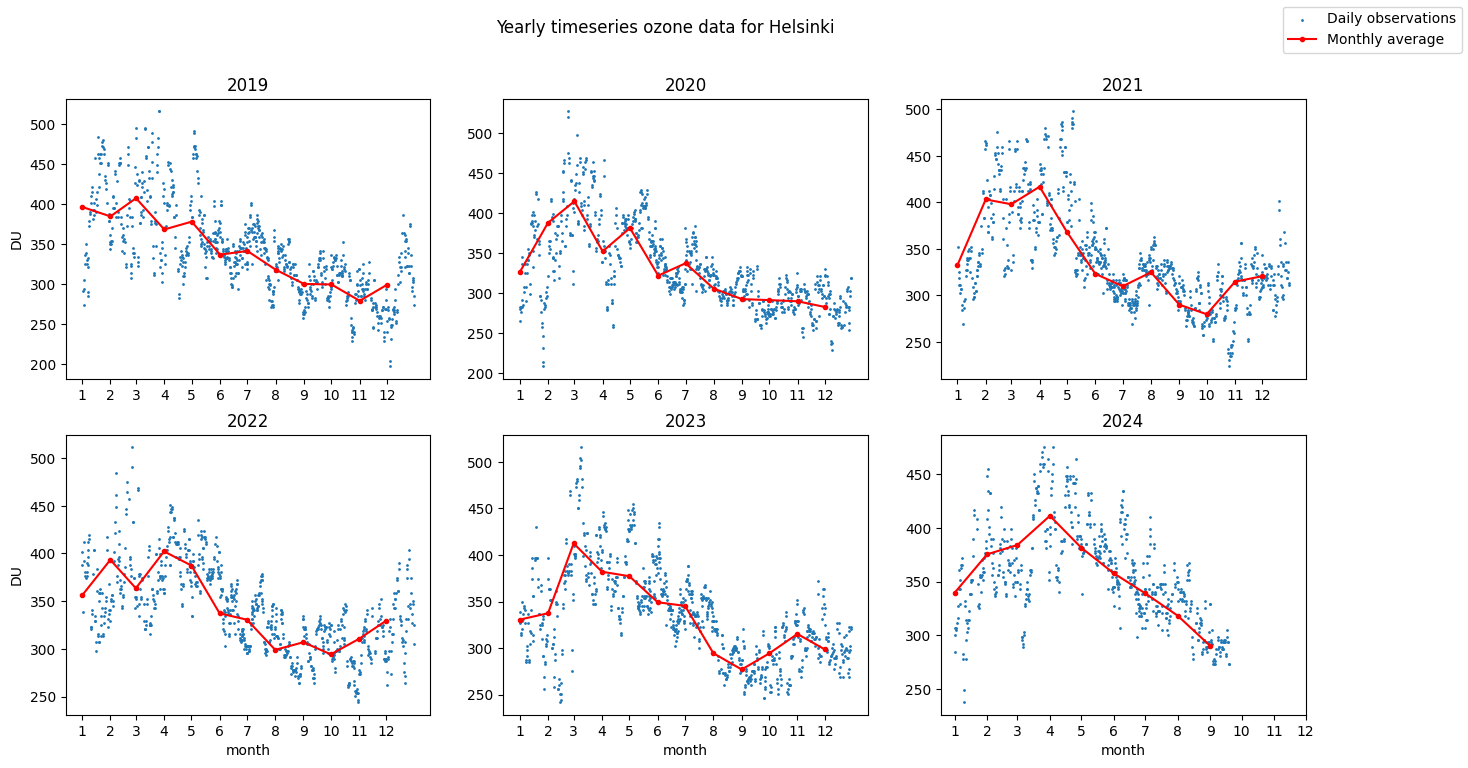

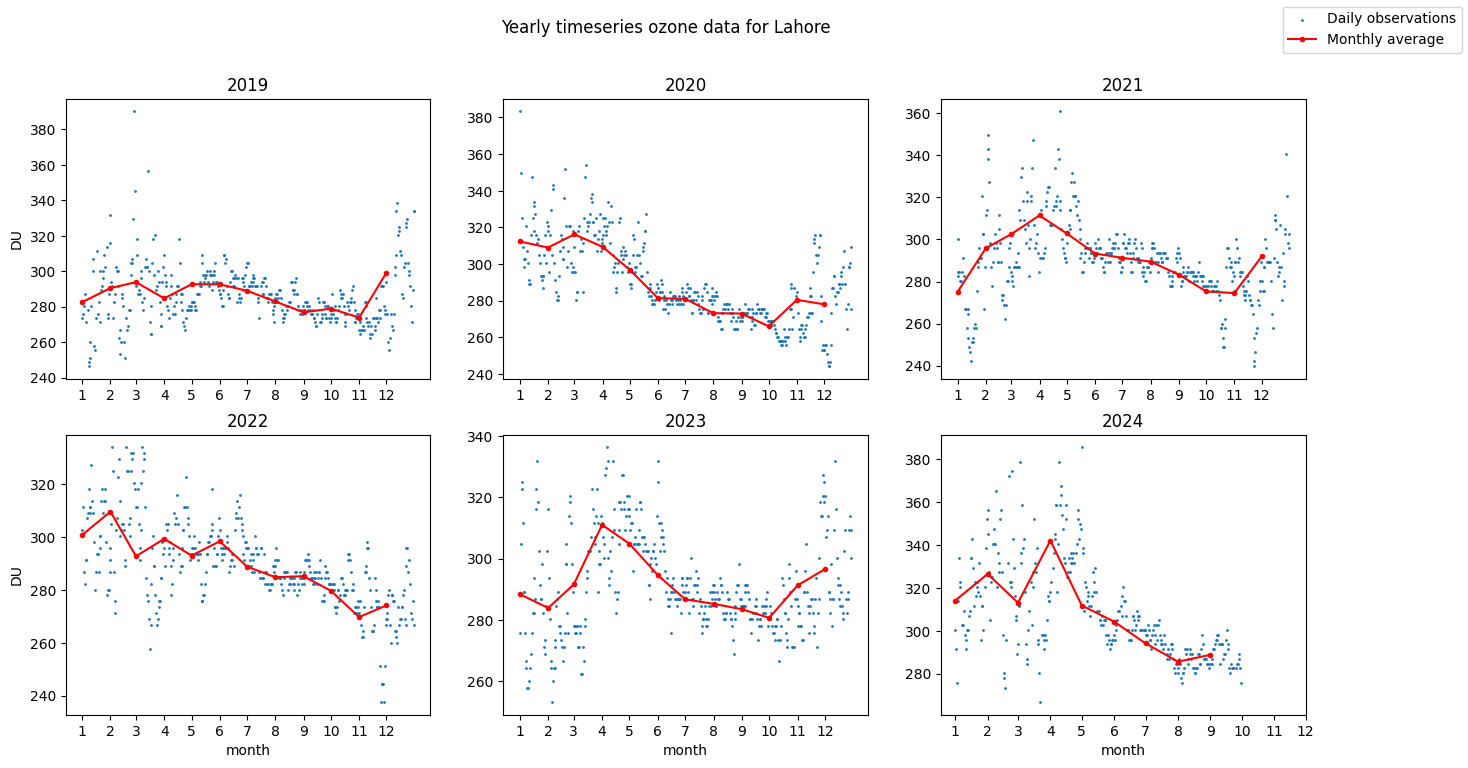

In [45]:
# Plot yearly data
cities['Helsinki'].plot_yearly_ozone_data()
cities['Lahore'].plot_yearly_ozone_data()

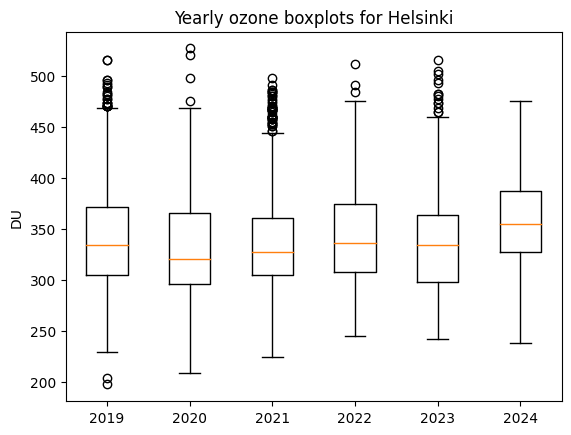

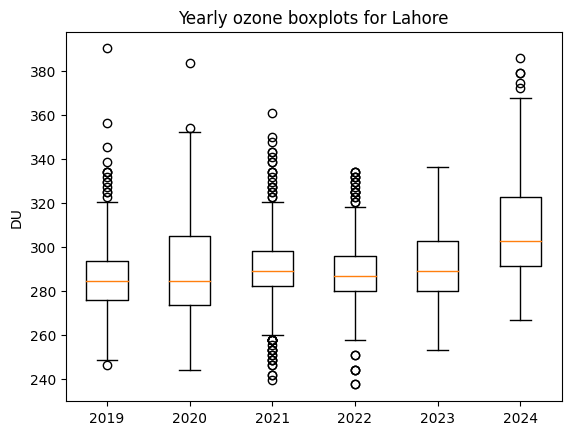

In [46]:
cities['Helsinki'].boxplot_yearly_ozone_data()
cities['Lahore'].boxplot_yearly_ozone_data()

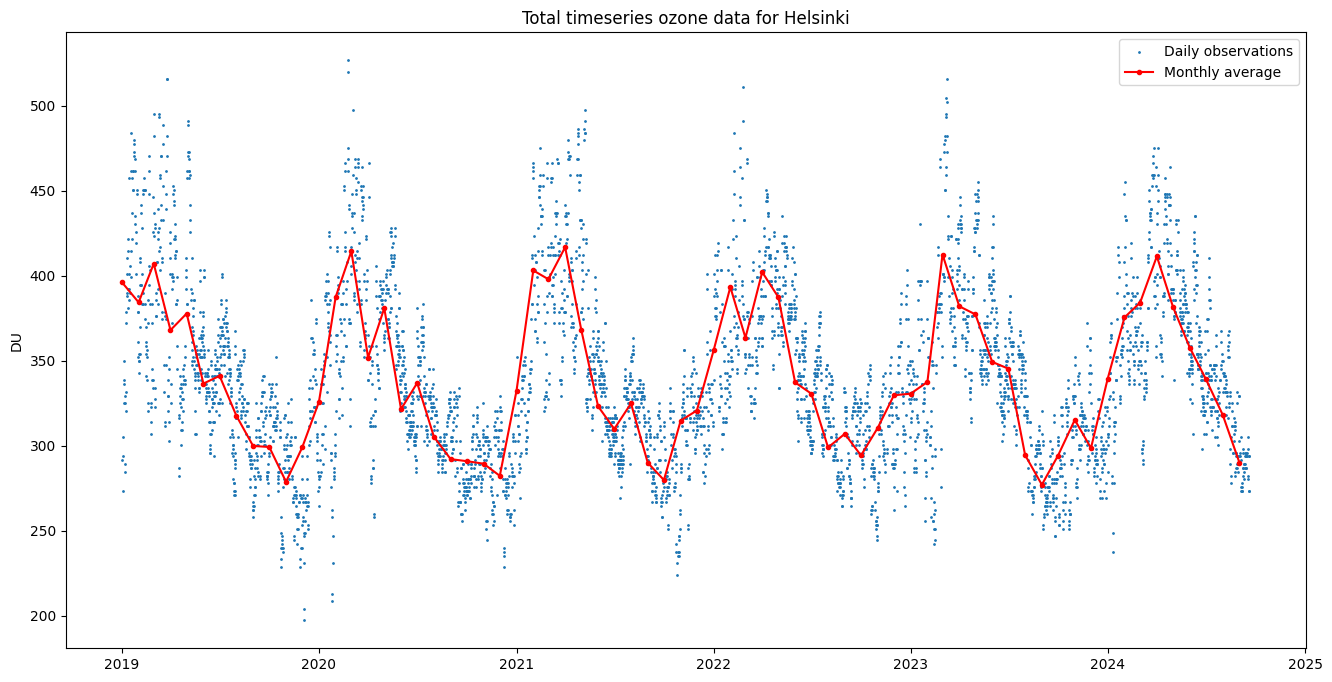

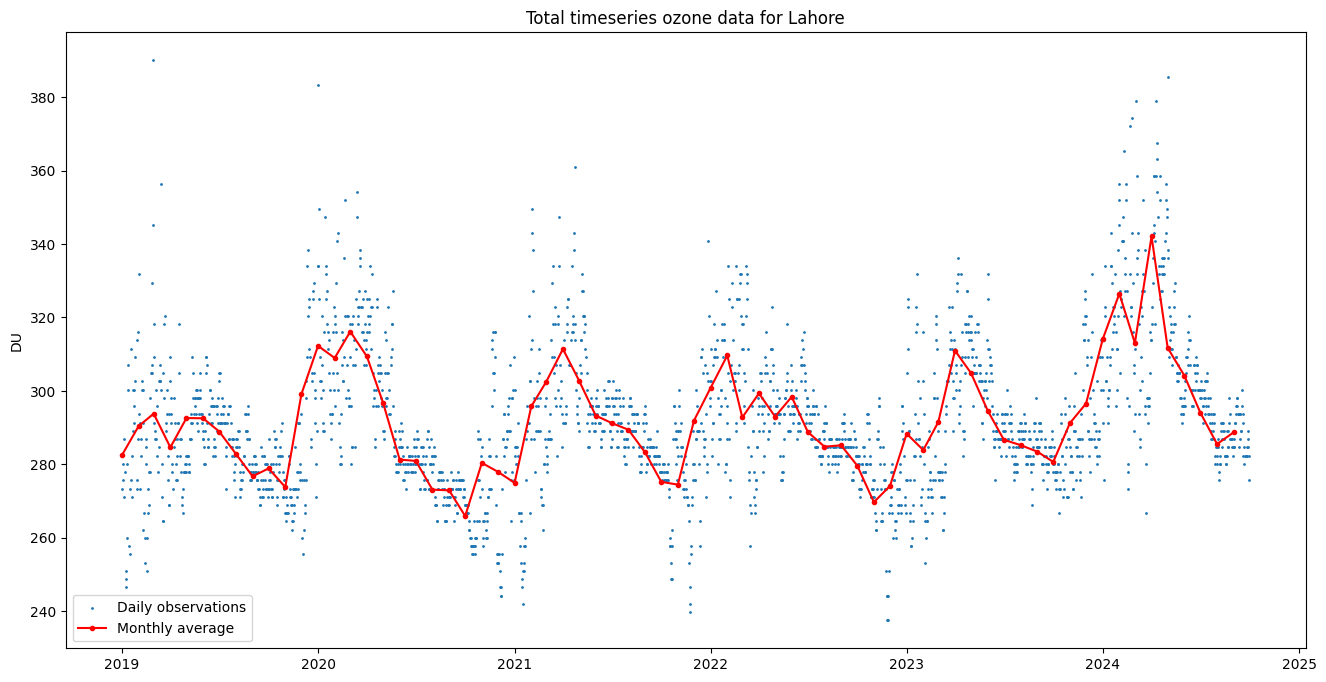

In [47]:
# Plot the whole timeseries as one
cities['Helsinki'].plot_all_ozone_data()
cities['Lahore'].plot_all_ozone_data()

In [49]:
cities = {'Helsinki': Location('Helsinki'),
          'Lahore': Location('Lahore')}


In [50]:
cities['Helsinki'].fit_sarima(order=(1,1,1), seasonal_order=(1,1,1,12))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                                 DU   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -252.362
Date:                            Fri, 11 Oct 2024   AIC                            514.723
Time:                                    20:47:19   BIC                            524.850
Sample:                                         0   HQIC                           518.649
                                             - 69                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0992      0.136     -0.727      0.467      -0.367       0.168
ma.L1         -0.9997     23.708   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [51]:
cities['Lahore'].fit_sarima(order=(1,1,1), seasonal_order=(1,1,1,12))


                                     SARIMAX Results                                      
Dep. Variable:                                 DU   No. Observations:                   69
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -207.156
Date:                            Fri, 11 Oct 2024   AIC                            424.312
Time:                                    20:47:28   BIC                            434.439
Sample:                                         0   HQIC                           428.238
                                             - 69                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6135      0.217      2.827      0.005       0.188       1.039
ma.L1         -0.9996     17.087   

<ipython-input-42-b6f303fd65c2>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df['Date'] = pd.date_range(start=self.ozone_monthly_df['Date'].max(), periods=steps+1, freq='M')[1:]


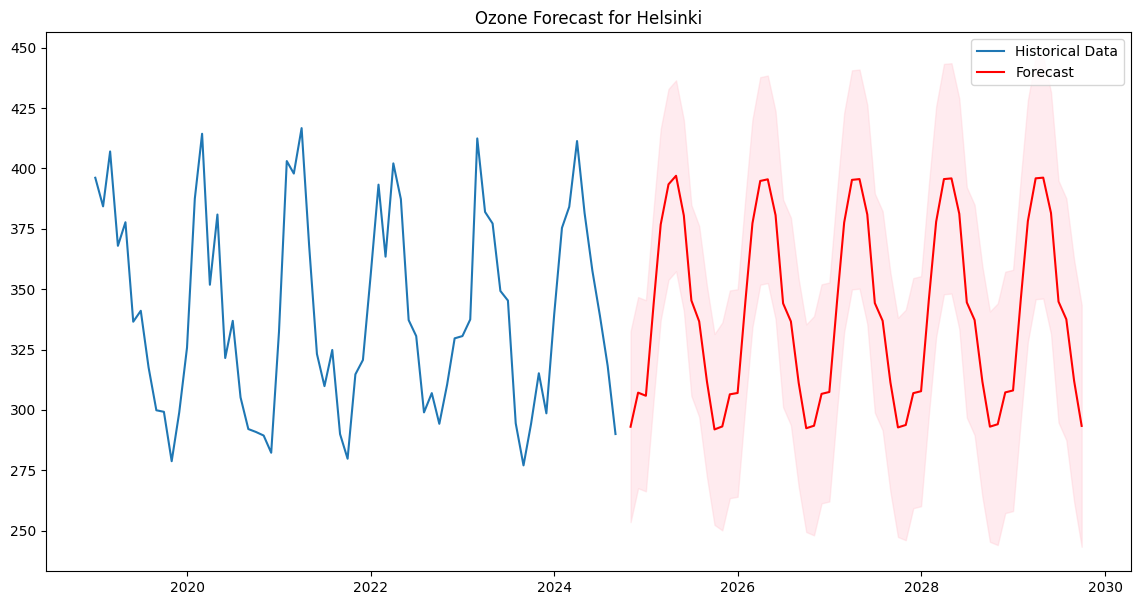

In [52]:
forecast_df = cities['Helsinki'].forecast_sarima(steps=60)
cities['Helsinki'].plot_forecast(forecast_df)


<ipython-input-42-b6f303fd65c2>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df['Date'] = pd.date_range(start=self.ozone_monthly_df['Date'].max(), periods=steps+1, freq='M')[1:]


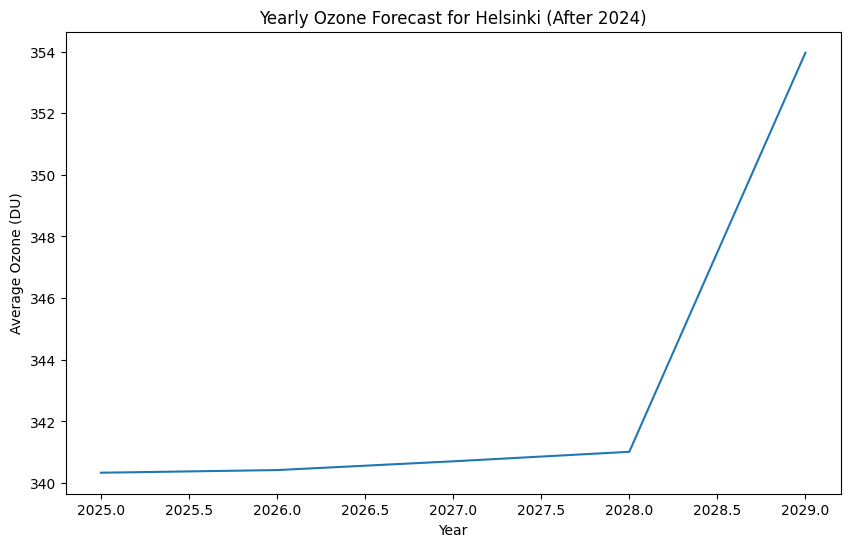

In [61]:
#plot yearly ozone data for Helsinki from the forecast, after 2024


forecast_df = cities['Helsinki'].forecast_sarima(steps=60)

# Filter forecast data for years after 2024
forecast_df_after_2024 = forecast_df[forecast_df['Date'].dt.year > 2024]

# Group by year and plot
yearly_forecasts = forecast_df_after_2024.groupby(forecast_df_after_2024['Date'].dt.year)['forecast'].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_forecasts.index, yearly_forecasts.values)
plt.title('Yearly Ozone Forecast for Helsinki (After 2024)')
plt.xlabel('Year')
plt.ylabel('Average Ozone (DU)')
plt.show()

<ipython-input-42-b6f303fd65c2>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df['Date'] = pd.date_range(start=self.ozone_monthly_df['Date'].max(), periods=steps+1, freq='M')[1:]


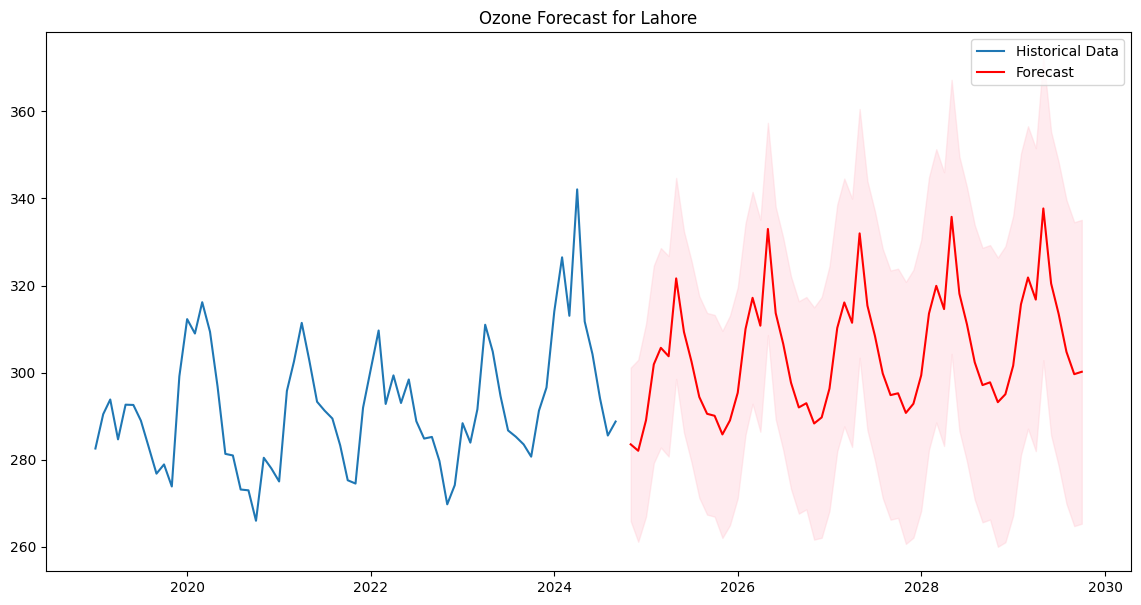

In [55]:
forecast_df = cities['Lahore'].forecast_sarima(steps=60)
cities['Lahore'].plot_forecast(forecast_df)

<ipython-input-42-b6f303fd65c2>:48: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_df['Date'] = pd.date_range(start=self.ozone_monthly_df['Date'].max(), periods=steps+1, freq='M')[1:]


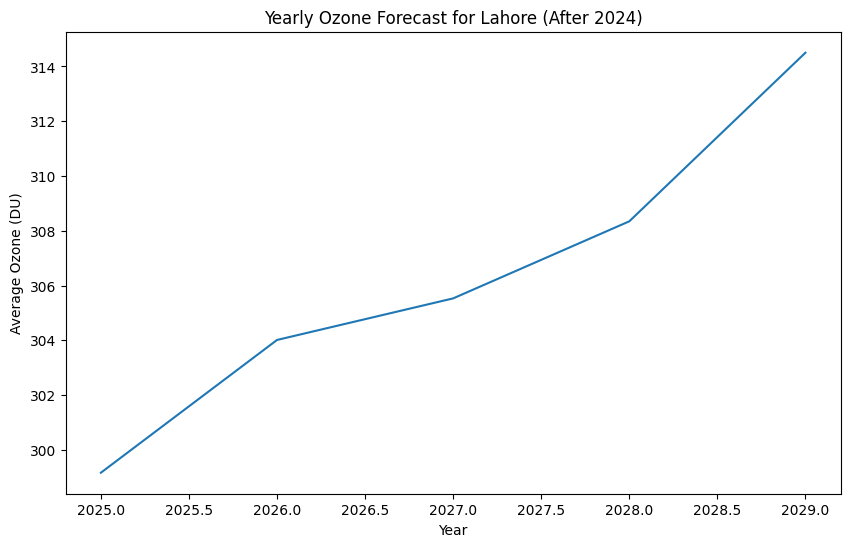

In [62]:
#plot yearly ozone data for Lahore from the forecast, after 2024


forecast_df = cities['Lahore'].forecast_sarima(steps=60)

# Filter forecast data for years after 2024
forecast_df_after_2024 = forecast_df[forecast_df['Date'].dt.year > 2024]

# Group by year and plot
yearly_forecasts = forecast_df_after_2024.groupby(forecast_df_after_2024['Date'].dt.year)['forecast'].mean()

plt.figure(figsize=(10, 6))
plt.plot(yearly_forecasts.index, yearly_forecasts.values)
plt.title('Yearly Ozone Forecast for Lahore (After 2024)')
plt.xlabel('Year')
plt.ylabel('Average Ozone (DU)')
plt.show()

In [66]:
#rolling window cross validation to validate and evaluate the model's performance over multiple time steps using mse and r^2

def rolling_window_cv_mse_r2(location, initial_train_size, forecast_horizon, step_size=1, order=(1,1,1), seasonal_order=(1,1,1,12)):
    """Performs rolling window cross-validation with SARIMA model and calculates MSE and R-squared."""
    ozone_monthly = location.ozone_monthly_df
    n_obs = len(ozone_monthly)

    mse_scores = []
    r2_scores = []

    for start in range(0, n_obs - initial_train_size - forecast_horizon, step_size):
        # Define train and test sets
        train = ozone_monthly.iloc[start:start + initial_train_size]
        test = ozone_monthly.iloc[start + initial_train_size:start + initial_train_size + forecast_horizon]

        # Fit SARIMA model on train set
        model = SARIMAX(train['DU'], order=order, seasonal_order=seasonal_order)
        sarima_fit = model.fit(disp=False)

        # Forecast the test set
        forecast = sarima_fit.get_forecast(steps=forecast_horizon)
        predicted_values = forecast.predicted_mean

        # Calculate MSE and R-squared for the current window
        mse = mean_squared_error(test['DU'], predicted_values)
        r2 = r2_score(test['DU'], predicted_values)
        mse_scores.append(mse)
        r2_scores.append(r2)

        print(f'Window {start} MSE: {mse}, R-squared: {r2}')

    # Average MSE and R-squared
    avg_mse = np.mean(mse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f'Average MSE: {avg_mse}, Average R-squared: {avg_r2}')
    return mse_scores, r2_scores


mse_scores_helsinki, r2_scores_helsinki = rolling_window_cv_mse_r2(cities['Helsinki'], initial_train_size=36, forecast_horizon=12)
mean_mse_helsinki = np.mean(mse_scores_helsinki)
mean_r2_helsinki = np.mean(r2_scores_helsinki)
print(f"Mean MSE for Helsinki: {mean_mse_helsinki}, Mean R-squared for Helsinki: {mean_r2_helsinki}")

mse_scores_lahore, r2_scores_lahore = rolling_window_cv_mse_r2(cities['Lahore'], initial_train_size=36, forecast_horizon=12)
mean_mse_lahore = np.mean(mse_scores_lahore)
mean_r2_lahore = np.mean(r2_scores_lahore)
print(f"Mean MSE for Lahore: {mean_mse_lahore}, Mean R-squared for Lahore: {mean_r2_lahore}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 0 MSE: 443.9599670875846, R-squared: 0.6589060566588916


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 1 MSE: 524.1563561133521, R-squared: 0.5948569639419719


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 2 MSE: 818.3483557357641, R-squared: 0.2127270581719224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 3 MSE: 616.702979991497, R-squared: 0.5744519238554988
Window 4 MSE: 679.6794700543593, R-squared: 0.4653762320657676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 5 MSE: 752.0946730571227, R-squared: 0.3713691965203674


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 6 MSE: 752.8616713586119, R-squared: 0.3764162796385808


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 7 MSE: 822.4042554928242, R-squared: 0.3174355352291621


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 8 MSE: 497.7524949980622, R-squared: 0.5976200189169576


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 9 MSE: 928.1750969376989, R-squared: 0.36701483454756967


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 10 MSE: 609.823202129499, R-squared: 0.5842038997421137


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 11 MSE: 601.0308914105589, R-squared: 0.5848642802117163


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 12 MSE: 676.4106763594746, R-squared: 0.5663877532835734


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 13 MSE: 1069.0429258550023, R-squared: 0.31480295885002596


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 14 MSE: 607.0355695828042, R-squared: 0.6396234499945983


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 15 MSE: 589.0293757929059, R-squared: 0.5780543485659191


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 16 MSE: 204.7828897982246, R-squared: 0.8786121501647984


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 17 MSE: 207.73212270375197, R-squared: 0.8789811952424257


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 18 MSE: 389.9265571547953, R-squared: 0.7754645936161972
Window 19 MSE: 306.0812259948405, R-squared: 0.8234382263998443


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 20 MSE: 358.5004708953604, R-squared: 0.7759942739027977
Average MSE: 593.1205346906712, Average R-squared: 0.5684095823581286
Mean MSE for Helsinki: 593.1205346906712, Mean R-squared for Helsinki: 0.5684095823581286


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 0 MSE: 155.0837864225197, R-squared: -0.2425196344193581


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 1 MSE: 83.5746414889569, R-squared: 0.2638543052027821


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 2 MSE: 188.35378002694608, R-squared: -1.5417909573310542
Window 3 MSE: 102.0440783209412, R-squared: -0.39907311579585447


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

Window 4 MSE: 212.2191905709134, R-squared: -0.958481947485831


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 5 MSE: 115.26146420999491, R-squared: 0.11396918145714408
Window 6 MSE: 63.39558828252976, R-squared: 0.4921671542254984


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

Window 7 MSE: 71.39117779532448, R-squared: 0.42844811787648274


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 8 MSE: 70.57830533809994, R-squared: 0.4340422910887448


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 9 MSE: 83.16797514425137, R-squared: 0.3383729165076539


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 10 MSE: 75.78086705293204, R-squared: 0.39099571937809885


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 11 MSE: 87.3243252700987, R-squared: 0.07883437200308141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 12 MSE: 99.74732883542356, R-squared: -0.32519452254332326


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 13 MSE: 144.63946330375973, R-squared: -0.2898868449091956


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 14 MSE: 1653.7553899940383, R-squared: -8.119127439042115


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 15 MSE: 329.36881461406455, R-squared: -0.6770861330940814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 16 MSE: 295.8761082197084, R-squared: 0.10985311329450154


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 17 MSE: 368.01030931123245, R-squared: -0.08314362260037989


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 18 MSE: 271.7932243202136, R-squared: 0.1880057290465622


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 19 MSE: 281.26082327690347, R-squared: 0.11815058755512886
Window 20 MSE: 305.0271015226959, R-squared: 0.041092770252634914
Average MSE: 240.8406544438833, Average R-squared: -0.45897704568251807
Mean MSE for Lahore: 240.8406544438833, Mean R-squared for Lahore: -0.45897704568251807


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [67]:
#rolling window cross validation to validate and evaluate the model's performance over multiple time steps using rmse and r^2

def rolling_window_cv_rmse_r2(location, initial_train_size, forecast_horizon, step_size=1, order=(1,1,1), seasonal_order=(1,1,1,12)):
    """Performs rolling window cross-validation with SARIMA model and calculates RMSE and R-squared."""
    ozone_monthly = location.ozone_monthly_df
    n_obs = len(ozone_monthly)

    rmse_scores = []
    r2_scores = []

    for start in range(0, n_obs - initial_train_size - forecast_horizon, step_size):
        # Define train and test sets
        train = ozone_monthly.iloc[start:start + initial_train_size]
        test = ozone_monthly.iloc[start + initial_train_size:start + initial_train_size + forecast_horizon]

        # Fit SARIMA model on train set
        model = SARIMAX(train['DU'], order=order, seasonal_order=seasonal_order)
        sarima_fit = model.fit(disp=False)

        # Forecast the test set
        forecast = sarima_fit.get_forecast(steps=forecast_horizon)
        predicted_values = forecast.predicted_mean

        # Calculate RMSE and R-squared for the current window
        rmse = np.sqrt(mean_squared_error(test['DU'], predicted_values))
        r2 = r2_score(test['DU'], predicted_values)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f'Window {start} RMSE: {rmse}, R-squared: {r2}')

    # Average RMSE and R-squared
    avg_rmse = np.mean(rmse_scores)
    avg_r2 = np.mean(r2_scores)
    print(f'Average RMSE: {avg_rmse}, Average R-squared: {avg_r2}')
    return rmse_scores, r2_scores


rmse_scores_helsinki, r2_scores_helsinki = rolling_window_cv_rmse_r2(cities['Helsinki'], initial_train_size=36, forecast_horizon=12)
mean_rmse_helsinki = np.mean(rmse_scores_helsinki)
mean_r2_helsinki = np.mean(r2_scores_helsinki)
print(f"Mean RMSE for Helsinki: {mean_rmse_helsinki}, Mean R-squared for Helsinki: {mean_r2_helsinki}")

rmse_scores_lahore, r2_scores_lahore = rolling_window_cv_rmse_r2(cities['Lahore'], initial_train_size=36, forecast_horizon=12)
mean_rmse_lahore = np.mean(rmse_scores_lahore)
mean_r2_lahore = np.mean(r2_scores_lahore)
print(f"Mean RMSE for Lahore: {mean_rmse_lahore}, Mean R-squared for Lahore: {mean_r2_lahore}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 0 RMSE: 21.070357545319077, R-squared: 0.6589060566588916


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 1 RMSE: 22.894461254053393, R-squared: 0.5948569639419719


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 2 RMSE: 28.606788630249362, R-squared: 0.2127270581719224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 3 RMSE: 24.833505189390745, R-squared: 0.5744519238554988
Window 4 RMSE: 26.070663015243, R-squared: 0.4653762320657676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 5 RMSE: 27.424344532862087, R-squared: 0.3713691965203674


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 6 RMSE: 27.438324864295414, R-squared: 0.3764162796385808


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 7 RMSE: 28.677591521828052, R-squared: 0.3174355352291621


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 8 RMSE: 22.31036743305816, R-squared: 0.5976200189169576


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 9 RMSE: 30.465966207190917, R-squared: 0.36701483454756967


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 10 RMSE: 24.694598642810515, R-squared: 0.5842038997421137


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 11 RMSE: 24.515931379626572, R-squared: 0.5848642802117163


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 12 RMSE: 26.007896423191834, R-squared: 0.5663877532835734


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 13 RMSE: 32.69622188961597, R-squared: 0.31480295885002596


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 14 RMSE: 24.63809184135014, R-squared: 0.6396234499945983


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 15 RMSE: 24.269927395707345, R-squared: 0.5780543485659191


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 16 RMSE: 14.310237237663973, R-squared: 0.8786121501647984


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 17 RMSE: 14.41291513552175, R-squared: 0.8789811952424257


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 18 RMSE: 19.7465581090679, R-squared: 0.7754645936161972
Window 19 RMSE: 17.495177221018384, R-squared: 0.8234382263998443


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 20 RMSE: 18.93410866387326, R-squared: 0.7759942739027977
Average RMSE: 23.881620672997038, Average R-squared: 0.5684095823581286
Mean RMSE for Helsinki: 23.881620672997038, Mean R-squared for Helsinki: 0.5684095823581286


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 0 RMSE: 12.453264087078523, R-squared: -0.2425196344193581


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 1 RMSE: 9.141916729491518, R-squared: 0.2638543052027821


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 2 RMSE: 13.724204167344134, R-squared: -1.5417909573310542
Window 3 RMSE: 10.101686904717509, R-squared: -0.39907311579585447


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

Window 4 RMSE: 14.567744869090529, R-squared: -0.958481947485831


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 5 RMSE: 10.735989205005513, R-squared: 0.11396918145714408
Window 6 RMSE: 7.962134656141515, R-squared: 0.4921671542254984


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/loc

Window 7 RMSE: 8.449330020500115, R-squared: 0.42844811787648274


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 8 RMSE: 8.401089532798704, R-squared: 0.4340422910887448


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 9 RMSE: 9.119647753298993, R-squared: 0.3383729165076539


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 10 RMSE: 8.705220678014546, R-squared: 0.39099571937809885


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 11 RMSE: 9.344748539693226, R-squared: 0.07883437200308141


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 12 RMSE: 9.987358451333543, R-squared: -0.32519452254332326


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 13 RMSE: 12.026614789863345, R-squared: -0.2898868449091956


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 14 RMSE: 40.666391406098946, R-squared: -8.119127439042115


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 15 RMSE: 18.148521003488536, R-squared: -0.6770861330940814


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 16 RMSE: 17.2010496255231, R-squared: 0.10985311329450154


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 17 RMSE: 19.18359479636787, R-squared: -0.08314362260037989


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 18 RMSE: 16.486152502030716, R-squared: 0.1880057290465622


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Window 19 RMSE: 16.77083251591594, R-squared: 0.11815058755512886
Window 20 RMSE: 17.465025093674956, R-squared: 0.041092770252634914
Average RMSE: 13.840119872736755, Average R-squared: -0.45897704568251807
Mean RMSE for Lahore: 13.840119872736755, Mean R-squared for Lahore: -0.45897704568251807


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
